## Importing Modules

In [1]:
import copy
import folium
import geopandas
import pandas

## Importing Input Data to Geodataframes

In [2]:
# Potential Mine Sites Shapefiles
FirstSites = geopandas.read_file(r"C:\Users\Charles\Desktop\GISY6048\Project Files\Meeting_2\FirstSites\FirstSites.shp")
SecondSites = geopandas.read_file(r"C:\Users\Charles\Desktop\GISY6048\Project Files\Meeting_2\SecondSites\SecondSites.shp")
ThirdSites = geopandas.read_file(r"C:\Users\Charles\Desktop\GISY6048\Project Files\Meeting_2\ThirdSites\ThirdSites.shp")
FourthSites = geopandas.read_file(r"C:\Users\Charles\Desktop\GISY6048\Project Files\Meeting_2\FourthSites\FourthSites.shp")
FifthSites = geopandas.read_file(r"C:\Users\Charles\Desktop\GISY6048\Project Files\Meeting_2\FifthSites\FifthSites.shp")

# Resource Data Shapefiles
Counties = geopandas.read_file(r"C:\Users\Charles\Desktop\GISY6048\Project Files\Meeting_2\Counties\NSCounties.shp")
Forest = geopandas.read_file(r"C:\Users\Charles\Desktop\GISY6048\Project Files\Meeting_2\Forest\Forest.shp")
Soils = geopandas.read_file(r"C:\Users\Charles\Desktop\GISY6048\Project Files\Meeting_2\Soils\Soils.shp")

## Exploring Input Data

In [3]:
FirstSites.head()

,UniqNum,Descriptio,BUFF_DIST,geometry
0,7,Goffs Scheelite Project,125,POINT (465162.152 4970041.228)
1,8,Meaghers Grant As Prospect,125,POINT (482618.026 4972930.476)
2,9,Dunbrack Mine,125,POINT (484965.54 4962788.011)


## Buffering Site Data

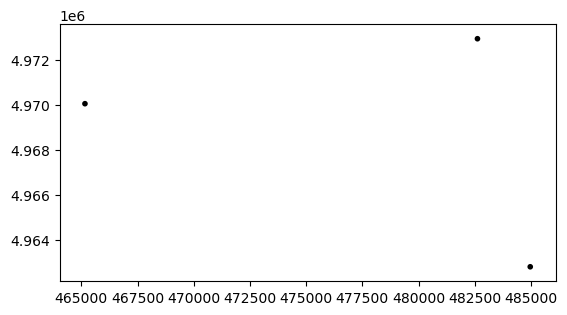

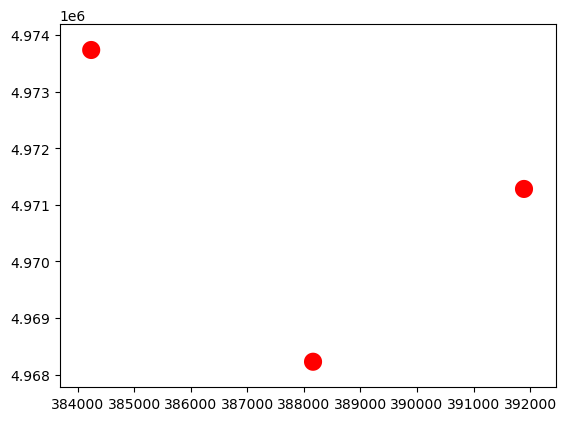

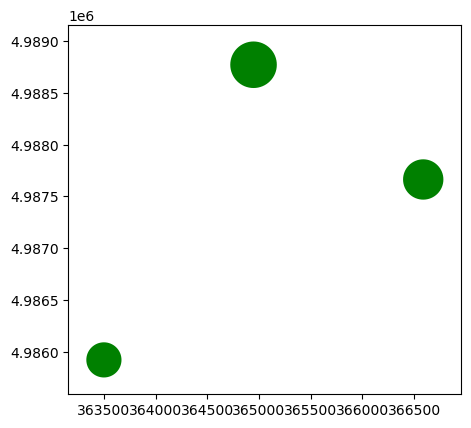

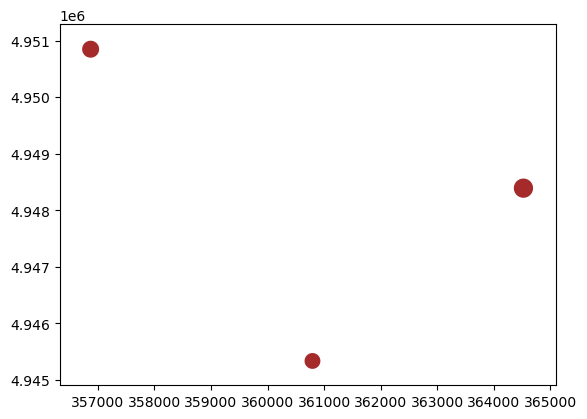

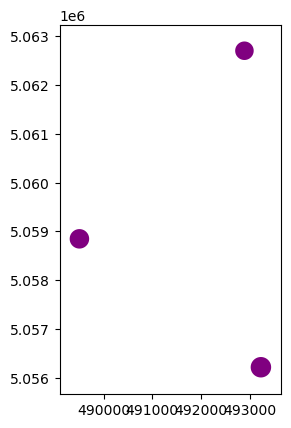

In [4]:
# Buffering first sites by site-specific distance
buff_dist = FirstSites["BUFF_DIST"]
FirstSites["buffered"] = FirstSites["geometry"].buffer(buff_dist).astype("geometry")
ax1 = FirstSites["buffered"].plot(color="black")  # Using geopandas interface with matplotlib to draw plots

# Buffering second sites by site-specific distance
buff_dist = SecondSites["BUFF_DIST"]
SecondSites["buffered"] = SecondSites["geometry"].buffer(buff_dist).astype("geometry")
ax2 = SecondSites["buffered"].plot(color="red")

# Buffering third sites by site-specific distance
buff_dist = ThirdSites["BUFF_DIST"]
ThirdSites["buffered"] = ThirdSites["geometry"].buffer(buff_dist).astype("geometry")
ax3 = ThirdSites["buffered"].plot(color="green")

# Buffering fourth sites by site-specific distance
buff_dist = FourthSites["BUFF_DIST"]
FourthSites["buffered"] = FourthSites["geometry"].buffer(buff_dist).astype("geometry")
ax4 = FourthSites["buffered"].plot(color="brown")

# Buffering fifth sites by site-specific distance
buff_dist = FifthSites["BUFF_DIST"]
FifthSites["buffered"] = FifthSites["geometry"].buffer(buff_dist).astype("geometry")
ax5 = FifthSites["buffered"].plot(color="purple")

## Reprojecting Layers

In [5]:
# Reprojecting counties to EPSG: 26290 (UTM NAD83 Zone 20)
Counties = Counties.to_crs(FirstSites.crs)
print("Counties Projection:", Counties.crs)

# Reprojecting forest
Forest = Forest.to_crs(FirstSites.crs)
print("Forest Projection:", Forest.crs)

# Reprojecting soils
Soils = Soils.to_crs(FirstSites.crs)
print("Soils Projection:", Soils.crs)

Counties Projection: EPSG:26920
Forest Projection: EPSG:26920
Soils Projection: EPSG:26920


## First Interactive Map

In [6]:
# Create an interactive map with the Counties layer
m = Counties.explore()

# Add the buffered sites layers to the same map
FirstSites.explore(m=m, color="black")
SecondSites.explore(m=m, color="red")
ThirdSites.explore(m=m, color="green")
FourthSites.explore(m=m, color="brown")
FifthSites.explore(m=m, color="purple")

# Show the map
m

## Merging Sites into One Geodataframe

In [7]:
# Add column with identifier for each set of sites
id_list = []
x = 1
while x < 16:
    if x <= 3:
        id_list.append(1)
    elif x <= 6:
        id_list.append(2)
    elif x <= 9:
        id_list.append(3)
    elif x <= 12:
        id_list.append(4)
    else:
        id_list.append(5)
    x += 1

# Merge all sites into one geodataframe
AllSites = geopandas.GeoDataFrame(pandas.concat([FirstSites, SecondSites, ThirdSites, FourthSites, FifthSites], ignore_index=True), columns=["Descriptio", "buffered"])
AllSites["geometry"] = AllSites["buffered"]
AllSites["SiteID"] = id_list

## Intersecting All Data

In [8]:
# Counties
SiteCounties = Counties.overlay(AllSites, how = "intersection")

# Forest
SiteForest = Forest.overlay(AllSites, how = "intersection")

# Soils
SiteSoils = Soils.overlay(AllSites, how = "intersection")

# Intersect the site resource data with each other
IntersectedSites = SiteCounties.overlay(SiteSoils, how = "intersection")
IntersectedSites = IntersectedSites.overlay(SiteForest, how = "intersection")

## Calculate Frequency Table

In [9]:
# Calculate the Area in hectares for each geometry in the GeoDataFrame
IntersectedSites["Area"] = (IntersectedSites["geometry"].area / 10000)

# Group by the relevant columns, calculate count and sum the area
freq_table = IntersectedSites.groupby(
    ["COUNTY", "Descriptio", "SP1", "HEIGHT", "SOILNAME", "STONINESS"]
).agg(
    Count = ("Area", "size"),  # Count of each group
    Total_Area_ha = ("Area", "sum")  # Sum of the areas in each group
).reset_index()

freq_table
freq_table.to_csv("frequency_table.csv", index=False)

## Mapping Tree Names and Stoniness Ratings with a Dictionary

In [10]:
# Creating a mapping dictionary for tree names
tree_name_mapping= {
    "BF" : "Fir",
    "BS" : "Black Spruce",
    "EH" : "Hemlock",
    "GB" : "Grey Birch",
    "RM" : "Red Maple",
    "RS" : "Red Spruce",
    "SM" : "Sugar Maple",
    "TA" : "Aspen",
    "UH" : "Unclassified Hardwood",
    "US" : "Unclassified Softwood",
    "WP" : "White Pine",
    "WS" : "White Spruce",
    "YB" : "Yellow Birch"
}

# Map tree names to new column and cast na values to " Unknown"
IntersectedSites['tree_name'] = IntersectedSites['SP1'].map(tree_name_mapping).fillna(" Unknown")

# Creating a mapping dictionary for stoniness ratings
stoniness_mapping= {
    "0" : "(0) Nonstony",
    "1" : "(1) Slightly Stony",
    "2" : "(2) Moderately Stony",
    "3" : "(3) Very Stony"
}

# Map stoniness ratings to new column and cast na values to " Unknown"
IntersectedSites['stoniness_rating'] = IntersectedSites['STONINESS'].map(stoniness_mapping).fillna(" Unknown")

## Centroid Points for Labels 

In [11]:
# Centroids of all intersected sites
IntersectedSites["geometry_centroid"] = IntersectedSites.centroid

# Create copy of IntersectedSites geodataframe
SiteLabels = copy.deepcopy(IntersectedSites)

# Set geometry of copied geodataframe to the centroid points and modify CRS to EPSG:4326 (WGS 84) for lat and long values
SiteLabels.set_geometry("geometry_centroid")
SiteLabels["geometry"] = SiteLabels["geometry_centroid"]
SiteLabels = SiteLabels.to_crs("EPSG:4326")
SiteLabels["geometry_centroid"] = SiteLabels["geometry"]

# Interactive Map of Intersected Sites

In [12]:
# List of fields visible in tooltip

tooltip_fields = [
    "COUNTY",
    "Descriptio",
    "Area",
    "tree_name",
    "stoniness_rating",
    "SOILNAME",
    "HEIGHT"
]

# Aliases for tooltip fields
tooltip_aliases = [
    "County",
    "Site Name",
    "Area in Hectares",
    "Dominant Tree Type",
    "Stoniness",
    "Soil Type",
    "Average Tree Height"
]

# Dominant tree type layer
m = IntersectedSites.explore(
    column="tree_name",
    style_kwds = {  # Style polygons for tree type layer
        "fillOpacity" : 1, # Set only fill to show
        "opacity" : 0
    },
    legend_kwds = {  # Style legend for tree type layer
        "caption" : "Dominant Tree Type",
        "colorbar" : False,
    },
    tooltip=tooltip_fields,  # Map tooltip fields to list
    tooltip_kwds={
        "aliases": tooltip_aliases  # Map tooltip aliases to list
    },
    name="Dominant Tree Type"
)

# Stoniness layer
IntersectedSites.explore(
    m=m,
    column="stoniness_rating",
    cmap='Greys',  # Set colormap for symbology
    style_kwds = {  # Style polygons for stoniness layer
        "fillOpacity" : 0,
        "opacity" : 1, # Set only stroke to show
        "weight" : 2
    },
    legend_kwds = {  # Style legend for stoniness layer
        "caption" : "Stoniness"
    },
    tooltip=tooltip_fields,  # Map tooltip fields to list
    tooltip_kwds={
        "aliases": tooltip_aliases  # Map tooltip aliases to list
    },
    name="Stoniness"
)

# Import folium plugins
import folium.plugins

# Add marker clusters to map to simplify label rendering at all scales
LabelClusters = folium.plugins.MarkerCluster(name="Labels").add_to(m)

# For loop to create a label marker for each polygon
for row in SiteLabels.itertuples():

    # Obtain coordinates for polygon centroid and process them into a lat, long list
    CentroidCoords = str(row[-1:])
    tidyCentroidCoords = CentroidCoords[9:-4]
    CentroidX, CentroidY = tidyCentroidCoords.split(" ", 1)
    CoordList = [CentroidY, CentroidX]

    # Obtain average height for each polygon and tidy
    AvgHeight = str(row[-51:-50])
    tidyAvgHeight = AvgHeight[1:-2]

    # Obtain soil type for each polygon and tidy
    SoilType = str(row[20:21])
    tidySoilType = SoilType[2:-3]

    # Grab site name for marker popup and tidy
    SiteName = str(row[4:5])
    tidySiteName = SiteName[2:-3]

    # Concatenate html formatted string to create a label feature
    HTMLString = "<div style='font-size: 12pt; font-family: Tahoma; width: 200px; border: 3px solid black;'><b>" + "Soil Type: " +\
        tidySoilType + "<br>" + "Average Height: " + tidyAvgHeight + "</b></div>"

    # Create icon style with BeautifyIcon plugin for each polygon
    icon_style = folium.plugins.BeautifyIcon(
        iconShape="rectangle",
        border_color="#0a0a0a",
        text_color="#1f2e5e",
        background_color="#ffffff50",
        html=HTMLString,
    )

    # Place marker on map for each polygon
    folium.Marker(location=CoordList, popup=tidySiteName, icon=icon_style).add_to(LabelClusters)

# Adding ability for user to enable/disable layers
folium.LayerControl().add_to(m)

# Display map
m